In [1]:
# --- 1) Setup & sanity checks
from pathlib import Path
import random, os, math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# EDIT if needed
SHAPENET_PATH = Path("../data/shapeNetCore").expanduser().resolve()
assert SHAPENET_PATH.exists(), f"ShapeNetCore folder not found: {SHAPENET_PATH}"
print("Dataset root:", SHAPENET_PATH)

device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 5-class subset mapping (your labels)
SYNSET_NAME = {
    "02808440": "bathtub",
    "02992529": "cellphone",
    "03046257": "clock",
    "03211117": "display",
    "03642806": "laptop",
}

Dataset root: /Users/brageramberg/Desktop/3DCNN/data/shapeNetCore
Using device: mps


In [2]:
# --- 2) BINVOX reader + index

def read_binvox(path: Path) -> np.ndarray:
    with open(path, "rb") as f:
        first = f.readline().strip()
        assert first == b"#binvox 1", f"Not a binvox file: {path}"
        dims = None
        line = f.readline().strip()
        while line and line != b"data":
            if line.startswith(b"dim"):
                parts = line.split()
                dims = tuple(int(x) for x in parts[1:])  # (X,Y,Z)
            line = f.readline().strip()
        assert dims is not None and line == b"data", f"Malformed binvox header: {path}"

        raw = np.frombuffer(f.read(), dtype=np.uint8)
        values = raw[0::2]; counts = raw[1::2].astype(np.int64)
        flat = np.repeat(values, counts)
        vol_zyx = flat.reshape((dims[2], dims[1], dims[0]))  # (Z,Y,X)
        vol_xyz = np.transpose(vol_zyx, (2, 1, 0))           # -> (X,Y,Z)
        return (vol_xyz > 0).astype(np.float32)

def find_voxel_path(model_dir: Path) -> Path | None:
    candidates = [
        model_dir / "models" / "model_normalized.binvox",
        model_dir / "model_normalized.binvox",
        model_dir / "models" / "model_normalized.surface.binvox",
        model_dir / "model_normalized.surface.binvox",
    ]
    for c in candidates:
        if c.exists():
            return c
    found = list(model_dir.rglob("*.binvox"))
    return found[0] if found else None

def build_index(root: Path, synset_name_map: dict[str, str], min_voxels: int = 50):
    records = []
    keep = set(synset_name_map.keys())
    for syn_dir in sorted([d for d in root.iterdir() if d.is_dir() and d.name in keep]):
        sid = syn_dir.name
        for md in sorted([d for d in syn_dir.iterdir() if d.is_dir()]):
            voxel = find_voxel_path(md)
            if voxel is None:
                continue
            vol = read_binvox(voxel)
            if float(vol.sum()) < float(min_voxels):
                continue
            records.append({
                "synset_id": sid,
                "synset_name": synset_name_map[sid],
                "model_id": md.name,
                "binvox": voxel
            })
    df = pd.DataFrame(records)
    print(f"Models with usable voxels (min_voxels={min_voxels}):", len(df))
    if len(df):
        display(df.groupby(["synset_id","synset_name"]).size().reset_index(name="count"))
    return df, records

df, records = build_index(SHAPENET_PATH, SYNSET_NAME, min_voxels=50)

Models with usable voxels (min_voxels=50): 3887


,synset_id,synset_name,count
0,02808440,bathtub,856
1,02992529,cellphone,831
2,03046257,clock,651
3,03211117,display,1090
4,03642806,laptop,459


In [3]:
# --- 3) Train/val split (80/20) stratified by class
from collections import defaultdict

by_class = defaultdict(list)
for r in records:
    by_class[r["synset_id"]].append(r)

train_records, val_records = [], []
rng = random.Random(SEED)
for sid, items in by_class.items():
    items = items.copy()
    rng.shuffle(items)
    n = len(items)
    n_val = max(1, int(0.2*n))
    val_records += items[:n_val]
    train_records += items[n_val:]

print("train:", len(train_records), "val:", len(val_records))

classes = sorted(SYNSET_NAME.keys())
cls_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_name = {i:SYNSET_NAME[c] for c,i in cls_to_idx.items()}

def show_counts(rows):
    from collections import Counter
    c = Counter([cls_to_idx[r["synset_id"]] for r in rows])
    return {idx_to_name[k]: v for k,v in sorted(c.items())}

print("Train class counts:", show_counts(train_records))
print("Val   class counts:", show_counts(val_records))

train: 3111 val: 776
Train class counts: {'bathtub': 685, 'cellphone': 665, 'clock': 521, 'display': 872, 'laptop': 368}
Val   class counts: {'bathtub': 171, 'cellphone': 166, 'clock': 130, 'display': 218, 'laptop': 91}


In [4]:
# --- 4) Fit into 32^3 + Dataset

FIXED = (32,32,32)  # (X,Y,Z)

def fit_into_cube(vol_xyz: np.ndarray, target=(32,32,32)) -> np.ndarray:
    """
    Take a binary (X,Y,Z) volume, crop to tight bbox, downsample with max-pooling
    so it fits inside `target`, then paste centered into a target cube.
    Returns float32 {0,1} with shape (X,Y,Z).
    """
    if vol_xyz.sum() == 0:
        return np.zeros(target, dtype=np.float32)

    # 1) tight bbox
    coords = np.argwhere(vol_xyz > 0)
    x0, y0, z0 = coords.min(axis=0)
    x1, y1, z1 = coords.max(axis=0) + 1
    sub = vol_xyz[x0:x1, y0:y1, z0:z1].astype(np.float32)  # (sx,sy,sz)

    # 2) downsample by max-pool so sub <= target in each dim
    sx, sy, sz = sub.shape
    tx, ty, tz = target
    kx = max(1, math.ceil(sx / tx))
    ky = max(1, math.ceil(sy / ty))
    kz = max(1, math.ceil(sz / tz))

    t = torch.from_numpy(sub)[None, None]  # (1,1,sx,sy,sz)
    if kx > 1 or ky > 1 or kz > 1:
        t = F.max_pool3d(t, kernel_size=(kx, ky, kz), stride=(kx, ky, kz))

    # DO NOT .squeeze(): keep the 3 spatial dims explicitly
    dx, dy, dz = t.shape[-3:]
    sub_ds = (t > 0).to(torch.float32)[0, 0].cpu().numpy()  # shape (dx,dy,dz)

    # 3) if still a hair larger due to ceil, center-crop
    if dx > tx:
        s = (dx - tx) // 2
        sub_ds = sub_ds[s:s+tx, :, :]
        dx = tx
    if dy > ty:
        s = (dy - ty) // 2
        sub_ds = sub_ds[:, s:s+ty, :]
        dy = ty
    if dz > tz:
        s = (dz - tz) // 2
        sub_ds = sub_ds[:, :, s:s+tz]
        dz = tz

    # 4) paste centered into output cube
    out = np.zeros((tx, ty, tz), dtype=np.float32)
    ox = (tx - dx) // 2
    oy = (ty - dy) // 2
    oz = (tz - dz) // 2
    out[ox:ox+dx, oy:oy+dy, oz:oz+dz] = sub_ds
    return out

from torch.utils.data import Dataset, DataLoader

class VoxelDataset(Dataset):
    def __init__(self, items, augment=False, thicken_radius=0):
        self.items = items
        self.augment = augment
        self.thicken_radius = thicken_radius
    def __len__(self): return len(self.items)
    def __getitem__(self, i):
        r = self.items[i]
        vol = read_binvox(r["binvox"])            # (X,Y,Z)
        vol = fit_into_cube(vol, FIXED)           # (X,Y,Z)
        vol_zyx = np.transpose(vol, (2,1,0))      # (Z,Y,X)
        x = torch.from_numpy(vol_zyx)[None].float()  # (1,D,H,W)

        # light dilation (optional)
        if self.thicken_radius > 0:
            k = 2*self.thicken_radius + 1
            kernel = torch.ones((1,1,k,k,k), dtype=x.dtype)
            x = (F.conv3d(x[None], kernel, padding=self.thicken_radius) > 0).float().squeeze(0)

        # flips (optional)
        if self.augment:
            if torch.rand(1) < 0.5: x = torch.flip(x, (1,))  # D
            if torch.rand(1) < 0.5: x = torch.flip(x, (2,))  # H
            if torch.rand(1) < 0.5: x = torch.flip(x, (3,))  # W

        nz = int(x.sum().item())
        if nz < 10:
            raise RuntimeError(f"Near-empty tensor after fit_into_cube: {r['binvox']} (sum={nz})")

        y = torch.tensor(cls_to_idx[r["synset_id"]], dtype=torch.long)
        return x, y

In [5]:
# --- 5) DataLoaders
CFG = {
    "batch_size": 16,
    "use_augmentation": True,
    "thicken_radius": 1,
}

train_ds = VoxelDataset(train_records, augment=CFG["use_augmentation"], thicken_radius=CFG["thicken_radius"])
val_ds   = VoxelDataset(val_records,   augment=False,                    thicken_radius=CFG["thicken_radius"])

train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=CFG["batch_size"], shuffle=False, num_workers=0)

# quick probe of the *actual* loaded tensors
xb, yb = next(iter(train_loader))
print("xb:", xb.shape, xb.dtype, "min/max/mean:", float(xb.min()), float(xb.max()), float(xb.mean()))
nz = [int(xb[i].sum().item()) for i in range(len(xb))]
print("nonzero per item:", nz, "| min:", min(nz))
print("yb classes:", sorted(set(yb.tolist())))

xb: torch.Size([16, 1, 32, 32, 32]) torch.float32 min/max/mean: 0.0 1.0 0.2525615692138672
nonzero per item: [8253, 10001, 8240, 6437, 11244, 6891, 13745, 8579, 13787, 8120, 5399, 5703, 6529, 5794, 6453, 7240] | min: 5399
yb classes: [0, 1, 2, 3, 4]


In [6]:
# --- 6) Model + optim
class Better3DCNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        def block(c_in, c_out, stride=1):
            return nn.Sequential(
                nn.Conv3d(c_in, c_out, 3, stride=stride, padding=1, bias=False),
                nn.BatchNorm3d(c_out),
                nn.ReLU(inplace=True),
            )
        self.stem = nn.Sequential(
            block(1,   32, 2),  # 32 -> 16
            block(32,  32, 1),
            block(32,  64, 2),  # 16 -> 8
            block(64,  64, 1),
            block(64, 128, 2),  # 8 -> 4
            block(128,128,1),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(128, n_classes),
        )
    def forward(self, x):
        return self.head(self.stem(x))

n_classes = len(classes)
model = Better3DCNN(n_classes).to(device)

# class weights (optional)
from collections import Counter
tr_counts = Counter([cls_to_idx[r["synset_id"]] for r in train_records])
n_per_class = np.array([tr_counts[i] for i in range(n_classes)], dtype=np.float32)
class_weights = (n_per_class.sum() / (n_classes * n_per_class))
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights)  # or None if you prefer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = None  # add OneCycle later if you want

In [7]:
# --- 7) Utils
@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    tot, n = 0.0, 0
    preds_all, tgts_all = [], []
    for xb,yb in loader:
        xb,yb = xb.to(device).float(), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        tot += loss.item()*xb.size(0); n += xb.size(0)
        preds_all.append(logits.argmax(1).cpu()); tgts_all.append(yb.cpu())
    if n == 0: return 0.0, 0.0, np.array([]), np.array([])
    preds = torch.cat(preds_all).numpy(); tgts = torch.cat(tgts_all).numpy()
    acc = (preds == tgts).mean()
    return tot/n, acc, preds, tgts

def train_one_epoch(model, loader, criterion, optimizer, scheduler=None, max_batches=None):
    model.train()
    tot, n = 0.0, 0
    for b,(xb,yb) in enumerate(loader):
        if max_batches is not None and b >= max_batches: break
        xb,yb = xb.to(device).float(), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if scheduler is not None: scheduler.step()
        tot += loss.item()*xb.size(0); n += xb.size(0)
    return tot/max(1,n)

# --- Smoke test on one real batch
xb, yb = next(iter(train_loader))
xb, yb = xb.to(device).float(), yb.to(device)
model_smoke = Better3DCNN(n_classes).to(device)
opt_smoke = torch.optim.AdamW(model_smoke.parameters(), lr=3e-3, weight_decay=0.0)
crit_smoke = nn.CrossEntropyLoss()

loss0 = None; best = float("inf")
for step in range(30):
    opt_smoke.zero_grad(set_to_none=True)
    logits = model_smoke(xb)
    loss = crit_smoke(logits, yb)
    loss.backward(); opt_smoke.step()
    v = float(loss.item()); best = min(best, v)
    if step == 0: loss0 = v
    if (step+1) % 10 == 0:
        print(f"[SMOKE] step {step+1}: loss={v:.4f} (best {best:.4f})")
print("[SMOKE RESULT]:", "PASS ✅" if best < loss0*0.95 else "FAIL ❌",
      f"(start {loss0:.4f} -> best {best:.4f})")

# --- Optional: short training loop
EPOCHS = 10
best_val = 0.0
for ep in range(1, EPOCHS+1):
    tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, scheduler)
    va_loss, va_acc, *_ = evaluate(model, val_loader, criterion)
    print(f"Epoch {ep:02d} | train {tr_loss:.4f} | val {va_loss:.4f}/{va_acc:.3f}")
    best_val = max(best_val, va_acc)
print("Best val acc:", best_val)

[SMOKE] step 10: loss=0.1052 (best 0.1052)
[SMOKE] step 20: loss=0.0241 (best 0.0241)
[SMOKE] step 30: loss=0.0077 (best 0.0077)
[SMOKE RESULT]: PASS ✅ (start 1.6827 -> best 0.0077)
Epoch 01 | train 0.7599 | val 0.5116/0.812
Epoch 02 | train 0.5065 | val 0.5131/0.793
Epoch 03 | train 0.4360 | val 0.3500/0.887
Epoch 04 | train 0.3899 | val 0.3114/0.906
Epoch 05 | train 0.3708 | val 0.3062/0.909
Epoch 06 | train 0.3278 | val 0.3124/0.897
Epoch 07 | train 0.3366 | val 0.2644/0.919
Epoch 08 | train 0.3030 | val 0.2658/0.902
Epoch 09 | train 0.3029 | val 0.2701/0.896
Epoch 10 | train 0.2830 | val 0.2515/0.915
Best val acc: 0.9188144329896907



VAL: loss=0.2515  acc=0.915

Per-class accuracy:
     bathtub: 0.965
   cellphone: 0.946
       clock: 0.854
     display: 0.858
      laptop: 0.989

Classification report:

              precision    recall  f1-score   support

     bathtub      0.902     0.965     0.932       171
   cellphone      0.882     0.946     0.913       166
       clock      0.874     0.854     0.864       130
     display      0.954     0.858     0.903       218
      laptop      0.978     0.989     0.984        91

    accuracy                          0.915       776
   macro avg      0.918     0.922     0.919       776
weighted avg      0.917     0.915     0.915       776


Confusion Matrix (counts):


,bathtub,cellphone,clock,display,laptop
bathtub,165,1,3,2,0
cellphone,1,157,6,2,0
clock,8,6,111,5,0
display,9,14,6,187,2
laptop,0,0,1,0,90



Confusion Matrix (row-normalized):


,bathtub,cellphone,clock,display,laptop
bathtub,0.965,0.006,0.018,0.012,0.000
cellphone,0.006,0.946,0.036,0.012,0.000
clock,0.062,0.046,0.854,0.038,0.000
display,0.041,0.064,0.028,0.858,0.009
laptop,0.000,0.000,0.011,0.000,0.989


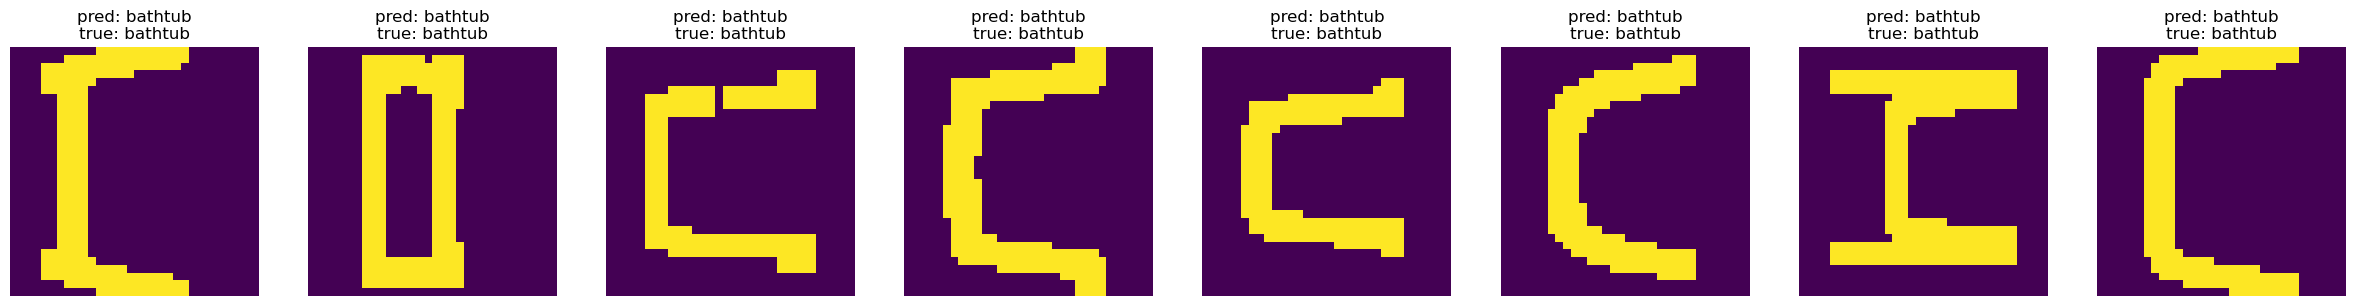

In [8]:
# === 10) Evaluation (metrics + confusion matrix + a few previews) ===
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import classification_report, confusion_matrix

# (optional) load best checkpoint if you saved one
ckpt_path = "best_3dcnn.pt"
if os.path.exists(ckpt_path):
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state["model"])
    print("Loaded best checkpoint:", ckpt_path)

@torch.no_grad()
def run_full_eval(model, loader, criterion):
    model.eval()
    tot, n = 0.0, 0
    preds_all, tgts_all = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device).float(), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        tot += float(loss.item()) * xb.size(0)
        n   += xb.size(0)
        preds_all.append(logits.argmax(1).cpu().numpy())
        tgts_all.append(yb.cpu().numpy())
    preds = np.concatenate(preds_all) if preds_all else np.array([])
    tgts  = np.concatenate(tgts_all)  if tgts_all  else np.array([])
    acc   = float((preds == tgts).mean()) if len(tgts) else 0.0
    return tot / max(1,n), acc, preds, tgts

val_loss, val_acc, preds, tgts = run_full_eval(model, val_loader, criterion)
print(f"\nVAL: loss={val_loss:.4f}  acc={val_acc:.3f}")

# label names in idx order
names = [idx_to_name[i] for i in range(len(classes))]

# per-class accuracy
per_class = {}
for i, name in enumerate(names):
    m = (tgts == i)
    per_class[name] = float((preds[m] == tgts[m]).mean()) if m.any() else float("nan")

print("\nPer-class accuracy:")
for k,v in per_class.items():
    print(f"  {k:>10s}: {v:.3f}")

# classification report
print("\nClassification report:\n")
print(classification_report(tgts, preds, target_names=list(names), digits=3, zero_division=0))

# confusion matrices
cm = confusion_matrix(tgts, preds, labels=list(range(len(names))))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1.0)

df_cm = pd.DataFrame(cm, index=names, columns=names)
df_cm_norm = pd.DataFrame(np.round(cm_norm, 3), index=names, columns=names)

print("\nConfusion Matrix (counts):")
display(df_cm)
print("\nConfusion Matrix (row-normalized):")
display(df_cm_norm)

# --- (optional) peek a few val samples with predictions ---
def preview_val_batch(num_items=8):
    xb, yb = next(iter(val_loader))
    xb, yb = xb.to(device).float(), yb.to(device)
    with torch.no_grad():
        logits = model(xb)
        pr = logits.argmax(1)
    # show central slices as a quick sanity (no heavy viz)
    import matplotlib.pyplot as plt
    k = min(num_items, xb.size(0))
    fig, axes = plt.subplots(1, k, figsize=(3*k, 3))
    if k == 1: axes = [axes]
    for i in range(k):
        vol = xb[i, 0].cpu().numpy()  # (D,H,W)
        z = vol.shape[0] // 2
        axes[i].imshow(vol[z], interpolation="nearest")
        axes[i].set_title(f"pred: {idx_to_name[int(pr[i])]}\ntrue: {idx_to_name[int(yb[i])]}")
        axes[i].axis("off")
    plt.tight_layout(); plt.show()

preview_val_batch()  # <- uncomment to visualize a few samples

In [13]:
# what’s in the sampled batch?
xb, yb = next(iter(val_loader))
vals, cnts = torch.unique(yb, return_counts=True)
print("Batch label mix:", {idx_to_name[int(v)]: int(c) for v,c in zip(vals, cnts)})

Batch label mix: {'bathtub': 16}


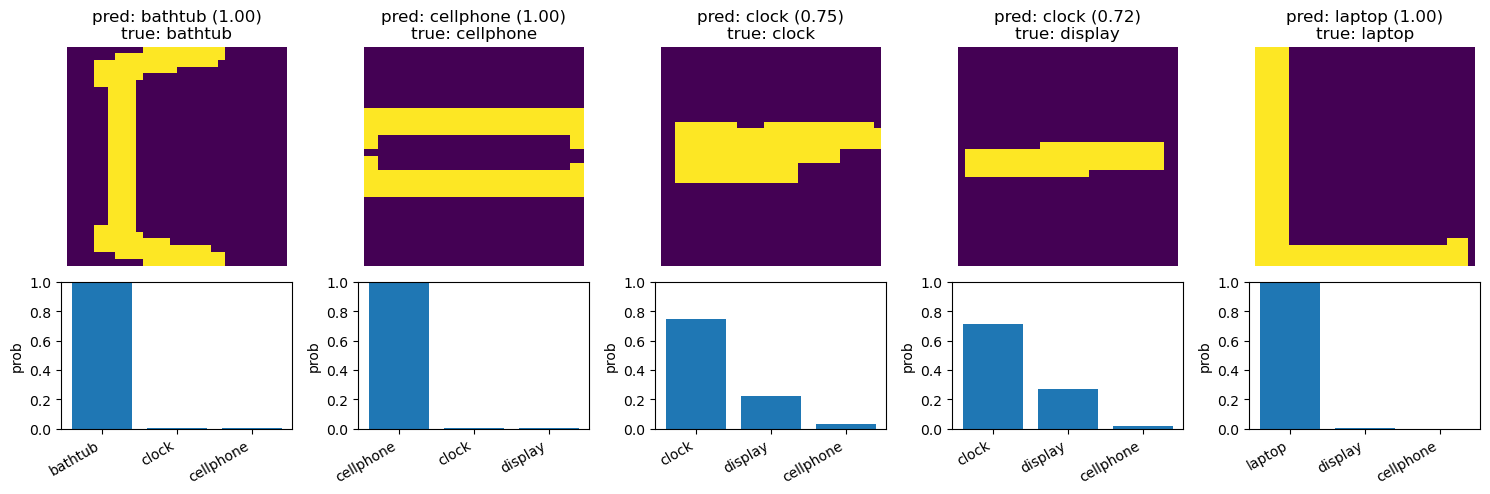

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

@torch.no_grad()
def preview_one_per_class(model, loader, classes=range(5), slice_axis='z'):
    model.eval()
    seen = {c: False for c in classes}
    keep = []

    for xb, yb in loader:
        xb = xb.to(device).float()
        yb = yb.to(device)
        logits = model(xb); probs = F.softmax(logits, dim=1)
        conf, pr = probs.max(dim=1)

        for i in range(xb.size(0)):
            c = int(yb[i].item())
            if not seen[c]:
                keep.append((xb[i].detach().cpu(), yb[i].item(), pr[i].item(), conf[i].item(), probs[i].detach().cpu()))
                seen[c] = True
                if all(seen.values()):
                    break
        if all(seen.values()):
            break

    k = len(keep)
    fig, axes = plt.subplots(2, k, figsize=(3.0*k, 5), gridspec_kw={'height_ratios':[3,2]})
    if k == 1: axes = np.array([[axes[0]],[axes[1]]])

    for i, (x, y, p, c, prob) in enumerate(keep):
        vol = x[0].numpy()  # (D,H,W) = (Z,Y,X)
        if slice_axis == 'z': sl = vol[vol.shape[0]//2]
        elif slice_axis == 'y': sl = vol[:, vol.shape[1]//2, :]
        else: sl = vol[:, :, vol.shape[2]//2]

        axes[0, i].imshow(sl, interpolation='nearest')
        axes[0, i].set_title(f"pred: {idx_to_name[int(p)]} ({c:.2f})\ntrue: {idx_to_name[int(y)]}")
        axes[0, i].axis('off')

        # top-3 bars
        p_np = prob.numpy()
        top_idx = p_np.argsort()[::-1][:3]
        axes[1, i].bar(range(3), p_np[top_idx])
        axes[1, i].set_xticks(range(3))
        axes[1, i].set_xticklabels([idx_to_name[int(j)] for j in top_idx], rotation=30, ha='right')
        axes[1, i].set_ylim(0, 1.0); axes[1, i].set_ylabel("prob")

    plt.tight_layout(); plt.show()

# usage
preview_one_per_class(model, val_loader, classes=range(len(classes)), slice_axis='z')

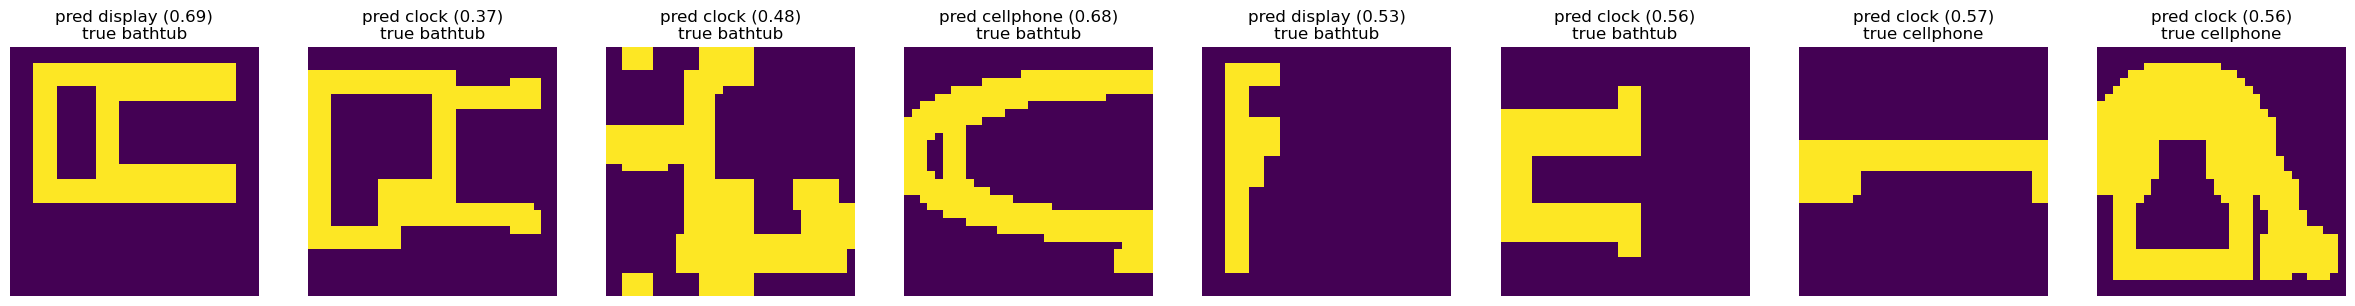

In [ ]:
# preview misclassifications only (to see failure modes)

@torch.no_grad()
def preview_misclassified(model, loader, max_items=8, slice_axis='z'):
    model.eval()
    got = []
    for xb, yb in loader:
        xb = xb.to(device).float(); yb = yb.to(device)
        logits = model(xb); probs = F.softmax(logits, dim=1)
        pred = logits.argmax(1)
        wrong = (pred != yb).nonzero(as_tuple=False).flatten()
        for i in wrong:
            got.append((xb[i].detach().cpu(), int(yb[i]), int(pred[i]), float(probs[i, pred[i]])))
            if len(got) >= max_items:
                break
        if len(got) >= max_items:
            break

    if not got:
        print("No misclassifications in the scanned batches.")
        return

    import matplotlib.pyplot as plt
    n = len(got)
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    if n == 1: axes = [axes]
    for i, (x, y, p, conf) in enumerate(got):
        vol = x[0].numpy()
        if slice_axis == 'z': sl = vol[vol.shape[0]//2]
        elif slice_axis == 'y': sl = vol[:, vol.shape[1]//2, :]
        else: sl = vol[:, :, vol.shape[2]//2]
        axes[i].imshow(sl, interpolation='nearest')
        axes[i].set_title(f"pred {idx_to_name[p]} ({conf:.2f})\ntrue {idx_to_name[y]}")
        axes[i].axis('off')
    plt.tight_layout(); plt.show()

# usage
preview_misclassified(model, val_loader, max_items=8)

In [10]:
@torch.no_grad()
def per_class_confidence(model, loader):
    model.eval()
    all_conf, all_pred = [], []
    for xb, yb in loader:
        xb = xb.to(device).float()
        logits = model(xb)
        probs = F.softmax(logits, dim=1)
        conf, pr = probs.max(dim=1)
        all_conf.extend(conf.cpu().numpy().tolist())
        all_pred.extend(pr.cpu().numpy().tolist())
    out = {}
    for c in range(len(names)):
        cls_conf = [all_conf[i] for i in range(len(all_conf)) if all_pred[i] == c]
        out[names[c]] = float(np.mean(cls_conf)) if cls_conf else float('nan')
    return out

print("Avg confidence per predicted class:")
print(per_class_confidence(model, val_loader))

Avg confidence per predicted class:
{'bathtub': 0.8935971375697297, 'cellphone': 0.9032119663243883, 'clock': 0.8787638448824094, 'display': 0.9020310880578294, 'laptop': 0.9868575859328975}


In [11]:
@torch.no_grad()
def per_true_class_confidence(model, loader):
    model.eval()
    out = {names[c]: {"count": 0, "avg_conf": None, "avg_conf_correct": None, "avg_conf_wrong": None}
           for c in range(len(names))}

    all_recs = []
    for xb, yb in loader:
        xb = xb.to(device).float()
        yb = yb.to(device)
        probs = F.softmax(model(xb), dim=1)
        conf, pr = probs.max(dim=1)
        for i in range(xb.size(0)):
            all_recs.append({
                "true": int(yb[i].item()),
                "pred": int(pr[i].item()),
                "conf": float(conf[i].item())
            })

    import pandas as pd
    df = pd.DataFrame(all_recs)
    for c in range(len(names)):
        dfc = df[df["true"] == c]
        if len(dfc) == 0:
            continue
        out[names[c]]["count"] = int(len(dfc))
        out[names[c]]["avg_conf"] = float(dfc["conf"].mean())
        out[names[c]]["avg_conf_correct"] = float(dfc[dfc["pred"] == c]["conf"].mean()) if (dfc["pred"] == c).any() else None
        out[names[c]]["avg_conf_wrong"] = float(dfc[dfc["pred"] != c]["conf"].mean()) if (dfc["pred"] != c).any() else None
    return out

print(per_true_class_confidence(model, val_loader))

{'bathtub': {'count': 171, 'avg_conf': 0.909022883713594, 'avg_conf_correct': 0.9220038999210705, 'avg_conf_wrong': 0.5520449380079905}, 'cellphone': {'count': 166, 'avg_conf': 0.9198408094515284, 'avg_conf_correct': 0.9380436562428809, 'avg_conf_wrong': 0.6023022598690457}, 'clock': {'count': 130, 'avg_conf': 0.8804105394161664, 'avg_conf_correct': 0.9198946732658524, 'avg_conf_wrong': 0.6497400732416856}, 'display': {'count': 218, 'avg_conf': 0.8769154539075467, 'avg_conf_correct': 0.9134916341241031, 'avg_conf_wrong': 0.6562784958270288}, 'laptop': {'count': 91, 'avg_conf': 0.9860942756736671, 'avg_conf_correct': 0.987191089656618, 'avg_conf_wrong': 0.8873810172080994}}


In [12]:
from collections import Counter
import numpy as np
import torch

@torch.no_grad()
def predicted_hist(model, loader):
    model.eval()
    preds = []
    for xb, _ in loader:
        xb = xb.to(device).float()
        preds.append(model(xb).argmax(1).cpu().numpy())
    preds = np.concatenate(preds)
    return Counter(preds)

pred_counts = predicted_hist(model, val_loader)
names = [idx_to_name[i] for i in range(len(idx_to_name))]
print("Predicted counts per class:")
for i, name in enumerate(names):
    print(f"{i:>2} {name:<10} -> {pred_counts.get(i, 0)}")

Predicted counts per class:
 0 bathtub    -> 183
 1 cellphone  -> 178
 2 clock      -> 127
 3 display    -> 196
 4 laptop     -> 92
